## Этап 1. Открываю данные и получаю общую информацию о датасете

#### Импортирую библиотеки

In [1]:
%%capture
import pandas as pd
import numpy as np
!pip install swifter
import swifter
import re
import nltk
from nltk.corpus import stopwords as nltk_stopwords
from nltk.stem import WordNetLemmatizer
nltk.download('wordnet')
import sys
!{sys.executable} -m pip install spacy
!{sys.executable} -m spacy download en
import spacy
!pip install wordcloud
from wordcloud import WordCloud
import matplotlib.pyplot as plt
%matplotlib inline

In [2]:
%%capture
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import GridSearchCV
from sklearn.ensemble import RandomForestClassifier
from sklearn.pipeline import Pipeline
from sklearn.metrics import f1_score
!pip install optuna
import optuna
from sklearn.model_selection import cross_val_score
from sklearn.metrics import f1_score
import catboost as cb
from catboost import Pool

In [3]:
try:
    df = pd.read_csv('toxic_comments.csv', index_col=0)
except:
    df = pd.read_csv('/datasets/toxic_comments.csv', index_col=0)

In [4]:
#смотрю общую информацию
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 159292 entries, 0 to 159450
Data columns (total 2 columns):
 #   Column  Non-Null Count   Dtype 
---  ------  --------------   ----- 
 0   text    159292 non-null  object
 1   toxic   159292 non-null  int64 
dtypes: int64(1), object(1)
memory usage: 3.6+ MB


In [5]:
#проверяю на дубликаты
df.duplicated().sum()

0

In [6]:
df.sample(5)

,text,toxic
101965,"""\n Speedy deletion of """"Andrewless"""" \n\n A p...",0
23028,User with a similar username? \n\nIts probably...,0
21176,Response to your Lieberman/Lamont post \n\n Yo...,0
157219,"""\n\n Another Toronto Cinema \n\nAlthough shor...",0
126323,"i am 39 and haveno kids, i am boring",0


0    0.898388
1    0.101612
Name: toxic, dtype: float64

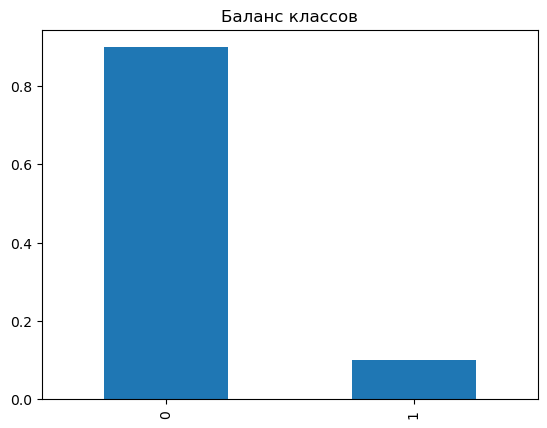

In [7]:
#смотрю частоту классов
class_frequency = df['toxic'].value_counts(normalize=True)
class_frequency.plot(kind='bar', title='Баланс классов')
class_frequency

In [8]:
df['text'][0]

"Explanation\nWhy the edits made under my username Hardcore Metallica Fan were reverted? They weren't vandalisms, just closure on some GAs after I voted at New York Dolls FAC. And please don't remove the template from the talk page since I'm retired now.89.205.38.27"

## Этап 2. Предобработка данных

#### Регулярные выражения

In [9]:
#применяю регулярные выражения
def clear_text(text):
    text_new = re.sub(r'[^a-zA-Z\']', ' ', text).strip()
    text_new = text_new.split()
    return " ".join(text_new).lower()

In [10]:
df['text'] = df['text'].apply(clear_text)

#### Стоп-слова и лемматизация

In [11]:
#импортирую стоп слова
nltk.download('stopwords')
stopwords = set(nltk_stopwords.words('english'))

In [12]:
nlp = spacy.load("en_core_web_sm", disable=['parser', 'ner'])

In [13]:
#лемматизирую текст 
def lemmatize(text):
    doc = nlp(text)
    lemmas = " ".join([token.lemma_ for token in doc])
    return lemmas

In [14]:
%%time
df['text'] = df['text'].swifter.apply(lemmatize)

Pandas Apply:   0%|          | 0/159292 [00:00<?, ?it/s]

CPU times: user 11min 32s, sys: 2.59 s, total: 11min 35s
Wall time: 11min 34s


In [15]:
#убираю стопслова
df['text'] = df['text'].apply(lambda x: ' '.join([word for word in x.split() if
                                                            word not in stopwords]))

In [16]:
#смотрю результат
print(df['text'][0])

explanation edit make username hardcore metallica fan revert vandalism closure gas I vote new york dolls fac please remove template talk page since I retire


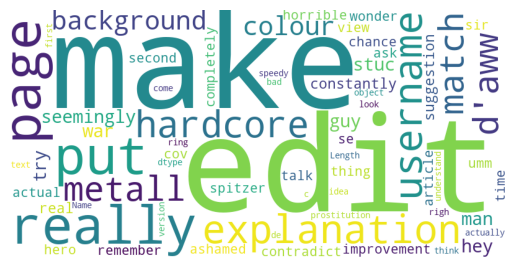

In [17]:
#строю облако слов
worldcloud = WordCloud(width=800, height=400, 
                       background_color='white').generate(str(df['text']))
plt.imshow(worldcloud)
plt.axis('off')
plt.show()

## Этап 3. Обучение моделей

In [18]:
#определяю признак и целевой признак
features = df['text']
target = df['toxic']

In [19]:
features_train, features_test, target_train, target_test = train_test_split(features, target,
                                                                           test_size=0.3,
                                                                           random_state=12345,
                                                                           stratify=target)

### Logistic Regression

In [20]:
%%time
pipeline_lr = Pipeline([
    ('tfidf', TfidfVectorizer()),
    ('model_lr', LogisticRegression(random_state=12345))
])

param_lr = {
    'tfidf__ngram_range': [(1,1), (2,2), (3,3)],
    'model_lr__C': [0.1, 10.0],
    'model_lr__max_iter': [500, 1000]
}

grid_search = GridSearchCV(pipeline_lr, param_lr, cv=3, scoring='f1', verbose=1)
grid_search.fit(features_train, target_train)

Fitting 3 folds for each of 12 candidates, totalling 36 fits
CPU times: user 22min 43s, sys: 4min 53s, total: 27min 37s
Wall time: 8min 8s


GridSearchCV(cv=3,
             estimator=Pipeline(steps=[('tfidf', TfidfVectorizer()),
                                       ('model_lr',
                                        LogisticRegression(random_state=12345))]),
             param_grid={'model_lr__C': [0.1, 10.0],
                         'model_lr__max_iter': [500, 1000],
                         'tfidf__ngram_range': [(1, 1), (2, 2), (3, 3)]},
             scoring='f1', verbose=1)

In [21]:
best_model_lr = grid_search.best_estimator_
best_params_lr = grid_search.best_params_
best_score_lr = grid_search.best_score_

In [22]:
print('Лучшие гиперпараметры:', best_params_lr)
print('Лучший f1:', best_score_lr)

Лучшие гиперпараметры: {'model_lr__C': 10.0, 'model_lr__max_iter': 500, 'tfidf__ngram_range': (1, 1)}
Лучший f1: 0.7700924859639056


### Random Forest

In [23]:
#подбираю лучшие гиперпараметры через optuna
def objective(trial):
    param_rf = {'n_estimators': trial.suggest_int('n_estimators', 50, 200, step=50),
                'max_depth': trial.suggest_int('max_depth', 10, 30, step=10),
                'min_samples_split': trial.suggest_int('min_samples_split', 2, 10, 2)
                
    }
    
    pipeline_rf = Pipeline([
    ('tfidf', TfidfVectorizer()),
    ('model_rf', RandomForestClassifier(**param_rf, random_state=12345))
    ])

    scores = cross_val_score(pipeline_rf, features_train, 
                             target_train, cv=3, scoring='f1')
    f1 = scores.mean()
    return f1


In [24]:
%%time
study_rf = optuna.create_study(direction='maximize')
study_rf.optimize(objective, n_trials=100)

CPU times: user 23min 59s, sys: 12.1 s, total: 24min 11s
Wall time: 24min 11s


In [25]:
best_params_rf = study_rf.best_params
best_score_rf = study_rf.best_value

In [26]:
print('Лучшие гиперпараметры', best_params_rf)
print('Лучший f1:', best_score_rf)

Лучшие гиперпараметры {'n_estimators': 50, 'max_depth': 30, 'min_samples_split': 4}
Лучший f1: 0.02024983478044988


### Logistic Regression (thresholding)

In [27]:
#выделю валидационную выборку
features_train_2, features_valid, target_train_2, target_valid = train_test_split(features_train, 
                                                                                  target_train,
                                                                                  test_size=0.3,
                                                                                  random_state=12345,
                                                                                  stratify=target_train)                                                                       

In [28]:
pipeline_lr_2 = Pipeline([
    ('tfidf', TfidfVectorizer()),
    ('model_lr_threshold', LogisticRegression(C=10.0, max_iter=500, random_state=12345))
])

pipeline_lr_2.fit(features_train_2, target_train_2)
prob_lr = pipeline_lr_2.predict_proba(features_valid)

best_f1_lr_threshold = 0
best_threshold = 0
for threshold in np.arange(0.1, 1, 0.02):
    predicted_lin_threshold = prob_lr[:, 1] > threshold
    f1_lr_threshold = f1_score(target_valid, predicted_lin_threshold)
    if f1_lr_threshold > best_f1_lr_threshold:
        best_f1_lr_threshold = f1_lr_threshold
        best_threshold = threshold
print('Лучший F1:', best_f1_lr_threshold, 'при пороге:', best_threshold)

Лучший F1: 0.7874650946323302 при пороге: 0.38


### CatBoost

In [32]:
#подбираю лучшие гиперпараметры через optuna
def objective(trial):
    param_cb = {'learning_rate': trial.suggest_float('learning_rate', 0.05, 0.1, step=0.01),
                'iterations': trial.suggest_int('iterations', 100, 200, step=50)
                
      
        
    }
                                    
    
    pipeline_cb = Pipeline([
    ('tfidf', TfidfVectorizer()),
    ('model_cb', cb.CatBoostClassifier(**param_cb, random_state=12345))
    ])
    
 
    scores = cross_val_score(pipeline_cb, features_train, 
                             target_train, cv=3, scoring='f1')
    f1 = scores.mean()
    return f1


In [33]:
%%time
study_cb = optuna.create_study(direction='maximize')
study_cb.optimize(objective, n_trials=100)

CPU times: user 17h 29min 55s, sys: 19min 5s, total: 17h 49min 1s
Wall time: 3h 23min 17s


In [34]:
best_params_cb = study_cb.best_params
best_score_cb = study_cb.best_value

In [35]:
print('Лучшие гиперпараметры', best_params_cb)
print('Лучший f1:', best_score_cb)

Лучшие гиперпараметры {'learning_rate': 0.1, 'iterations': 200}
Лучший f1: 0.7075284795238352


## Выводы

### Сравнение

In [38]:
df_model = pd.DataFrame({'модель': ['log regression', 'log regression (thresholding)', 'random forest', 'catboost'],
                        'f1': [best_score_lr, best_f1_lr_threshold, best_score_rf , best_score_cb]})
df_model

,модель,f1
0,log regression,0.770092
1,log regression (thresholding),0.787465
2,random forest,0.020250
3,catboost,0.707528


- Видим, что модель random forest имеет крайне низкую эффективность для решения данной задачи.
- На тестовой выборке применяю лучшую модель - логистическую регрессию c нестандартным порогом.

### Тестирование лучшей модели

In [41]:
prob_test = pipeline_lr_2.predict_proba(features_test)
predictions_test = prob_test[:, 1] > best_threshold
f1_best_model = f1_score(target_test, predictions_test)

In [42]:
print('F1 лучшей модели на тестовой выборке:', f1_best_model)

F1 лучшей модели на тестовой выборке: 0.7818221928082948


### Заключение

Была поставлена задача провести обучение модели для классификации комментариев на негативные и позитивные. В качестве целевой метрики была определена метрика F1 (значение > 0.75). Исходные данные представляют собой необработанные тексты комментариев с разметкой о токсичности.
В ходе исследования были проведены следующие этапы:
- Предобработка текста (регулярные выражения, лемматизация, удаление стоп-слов);
- Обучение и сравнение моделей (логистическая регрессия, random forest, catboost);
- Лучший результат из рассмотренных моделей показала логистическая регрессия с настроенным порогом (0.38);
- На тестовой выборке отобранная лучшая модель показала результат 0.7818, что соответствует исходной цели.